# Bayesian logistic regression:

In [1]:
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

from coinem.model import AbstractModel
from coinem.dataset import Dataset

## Model

We employ standard Bayesian logistic regression with Gaussian priors. That is, we assume that the datapoints’ labels are conditionally independent given the features $f$ and regression weights $x \in \mathbb{R}^{Dy:=9}$, each label with Bernoulli law and mean $s(f^T x)$, where $s(z) := e^z/(1 + e^z)$ denotes the standard logistic function; and we assign the prior $\mathcal{N}(x; \theta I_{D_y}, 5I_{D_y})$ to the weights $x$, where $\theta$ denotes the (scalar) parameter to be estimated. The model’s density is given by:

$$ p_\theta(x, y) = \mathcal{N}(x; \theta I_{D_y}, 5I_{D_y}) \prod_{f, l} s(f^{T} x)^{l} \left[ 1 - s(f^{T} x) \right]^{1-l}$$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [2]:
from jaxtyping import Array, Float, PyTree
import tensorflow_probability.substrates.jax.bijectors as tfb

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D 1"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """

        # Compute linear predictor.
        z = jnp.matmul(data.X, latent)

        # likelihood
        log_lik = tfd.Bernoulli(logits=z).log_prob(data.y.squeeze()).sum()

        # Prior
        log_prior = tfd.Normal(loc=theta, scale=5.0).log_prob(latent).sum().squeeze()

        # Compute log-probability.
        return log_lik + log_prior
    
    def optimal_theta(self, latent_particles: PyTree[Float[Array, "N D *"]]) -> PyTree[Float[Array, "Q *"]]:
        return latent_particles.mean().reshape(-1)

### Dataset:

We use the Wisconsin Breast Cancer dataset Y (Wolberg and Mangasarian, 1990), created by Dr. William H. Wolberg at the University of Wisconsin Hospitals, and freely available at
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).
It contains 683 datapoints5 each with nine features f ∈ R9 extracted from a digitized image of a fine needle aspirate of a breast mass and an accompanying label l indicating whether the mass is benign (l = 0) or malign (l = 1). We normalize the features so that each has mean zero and unit standard deviation across the dataset. We split the dataset into 80/20 training and testing sets, Ytrain and Ytest.

In [3]:
# OS and wget to load dataset.
import os
import wget
import numpy as np

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch dataset from repository:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

# Load dataset:
dataset = np.loadtxt('breast-cancer-wisconsin.data', dtype=str, delimiter=',')

# Delete local copy of dataset to avoid duplicates with multiple notebook runs:
os.remove('breast-cancer-wisconsin.data')

# Remove datapoints with missing attributes and change dtype to float:
dataset = dataset[~(dataset == '?').any(axis=1), :].astype(float)

# Extract features and labels, and normalize features:
features = np.array(dataset[:, 1:10] - dataset[:, 1:10].mean(0))
features = features/features.std(0)
labels = np.array([(dataset[:, 10]-2)/2]).transpose()

# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=42)

100% [..............................................................................] 19889 / 19889

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [4]:
# Define the model:
model = LogisticRegression()
data = Dataset(ftrain, ltrain)

# Unit tests:
N = 10  # Number of particles.
D = 9  # Dimension of latent space.

theta = jnp.array([0.0]) # Parameters of the model.
latent_particles = jnp.zeros((N, D)) # Latent particles.

f = ftrain # Features
y = ltrain # Labels

s = 1.0/(1.0+jnp.exp(-jnp.matmul(f, latent_particles.T)))
score_latent_particles = (jnp.matmul((y-s).T, f).T - (latent_particles.T)/5).T
average_score_theta = jnp.array([[2 * (latent_particles.T).sum(0).mean()/5]])

assert jnp.allclose(model.score_latent_particles(latent_particles, theta, data), score_latent_particles) # Gradient of log p(y|x) wrt latent particles
assert jnp.allclose(model.average_score_theta(latent_particles, theta, data), average_score_theta) # Average gradient of log p(y|x) wrt theta

## Section 4.1

We're now ready to run all of the methods. 

In [28]:
from coinem.zoo import coin_svgd, pgd, ada_pgd, ada_svgd, soul, adam_svgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_pgd

results_dir = "results/bayes_lr/param_and_posterior"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2,random_state=42)

model = LogisticRegression()
data = Dataset(ftrain, ltrain)
    
import jax.random as jr
key = jr.PRNGKey(42)

K = 800  # Number of steps.
N = 100 # Number of particles.

# list of saved results
results_id_list = ["", # results in Fig. 3 (Sec. 4.2)
                   "_10_init", # results in Fig. 10a (App. F.2)
                   "_minus10_init", # results in Fig. 10b (App F.2)
                   "_small_lr", # results in Fig. 11b (App. F.2)
                   "_big_lr", # results in Fig. 11c (App. F.2)
                  ]

# set results_id to one of the entries in results_id_list to generate those results
results_id = "" 

th0 = jnp.array([0.0])  # Parameter estimate.
X0 = jr.normal(key, (N, D))  # Particle cloud.

# load = True: load in existing results corresponding to results_id
# load = False: run experiments from scratch
load = True
if load:
    X_coin, th_coin = np.load(results_dir + "/" + "X_coin" + results_id + ".npy"), np.load(results_dir + "/" + "th_coin" + results_id + ".npy")
    X_svgd, th_svgd = np.load(results_dir + "/" + "X_svgd" + results_id + ".npy"), np.load(results_dir + "/" + "th_svgd" + results_id + ".npy")
    X_pgd, th_pgd = np.load(results_dir + "/" + "X_pgd" + results_id + ".npy"), np.load(results_dir + "/" + "th_pgd" + results_id + ".npy")
    X_soul, th_soul = np.load(results_dir + "/" + "X_soul" + results_id + ".npy"), np.load(results_dir + "/" + "th_soul" + results_id + ".npy")
    X_pmgd, th_pmgd = np.load(results_dir + "/" + "X_pmgd" + results_id + ".npy"), np.load(results_dir + "/" + "th_pmgd" + results_id + ".npy")
    
    
else:
    X_coin, th_coin = coin_svgd(model, data, X0, th0, K)
    X_svgd, th_svgd = standard_svgd(model, data, X0, th0, K, latent_step_size=5e-3, theta_step_size=5e-3)
    X_pgd, th_pgd = pgd(model, data, X0, th0, K, latent_step_size=1e-3, theta_step_size=1e-3)
    X_soul, th_soul = soul(model, data, X0, th0, K, latent_step_size=1e-3, theta_step_size=1e-3)
    X_pmgd, th_pmgd = marginal_pgd(model, data, X0, th0, K, latent_step_size=1e-3)

    save = True
    if save:
        np.save(results_dir + "/" + "X_coin" + results_id, X_coin)
        np.save(results_dir + "/" + "X_svgd" + results_id, X_svgd)
        np.save(results_dir + "/" + "X_pgd" + results_id, X_pgd)
        np.save(results_dir + "/" + "X_soul" + results_id, X_soul)
        np.save(results_dir + "/" + "X_pmgd" + results_id, X_pmgd)
        
        np.save(results_dir + "/" + "th_coin" + results_id, th_coin)
        np.save(results_dir + "/" + "th_svgd" + results_id, th_svgd)
        np.save(results_dir + "/" + "th_pgd" + results_id, th_pgd)
        np.save(results_dir + "/" + "th_soul" + results_id, th_soul)
        np.save(results_dir + "/" + "th_pmgd" + results_id, th_pmgd)

## Fig. 3(a)

First we'll plot the parameter estimates vs the iterations

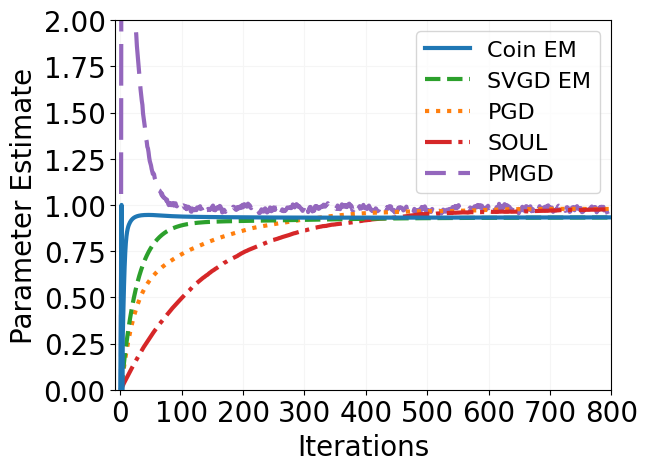

In [31]:
# Set up directory
fig_dir = "figures/bayes_lr/param_and_posterior"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
fig, ax = plt.subplots(1)
plt.plot(th_coin[:, 0].squeeze(), label='Coin EM', color="C0", linewidth=3, zorder=6, linestyle="solid")
plt.plot(th_svgd[:, 0].squeeze(), label='SVGD EM', color="C2", linewidth=3, zorder=5, linestyle='dashed')
plt.plot(th_pgd[:, 0].squeeze(), label='PGD', linewidth=3, color="C1", zorder=3, linestyle='dotted')
plt.plot(th_soul[:, 0].squeeze(), label='SOUL', linewidth=3, color="C3", zorder=4, linestyle='dashdot')
plt.plot(th_pmgd[:, 0].squeeze(), label='PMGD', linewidth=3, color="C4", zorder=1, linestyle=(5, (10, 3)))
#plt.axhline(y=1, linestyle='solid', color='black', linewidth=2)
plt.legend(loc='upper right',prop={'size': 16})
plt.xlim([-K/100, K])
plt.ylim(0,2)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Parameter Estimate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(color='whitesmoke')
ax.set_axisbelow(True)
plt.savefig(fig_dir + "/" + "param_plot" + results_id + ".pdf", dpi=300, bbox_inches="tight")
plt.show()

## Fig. 3(b)

Next we can take a look at the corresponding posterior density estimates.

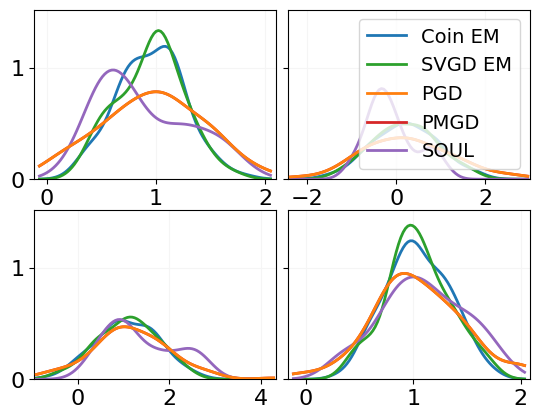

In [32]:
# Extract final particle clouds X^{1:N}_K:
q_pgd = X_pgd[-1, :, :]
q_soul = X_soul[-1, :, :]
q_coin = X_coin[-1, :, :]
q_pmgd = X_pmgd[-1, :, :]
q_svgd = X_svgd[-1, :, :]

# Generate and plot KDEs:
from scipy import stats  # stats to generate KDEs.
fig, axs = plt.subplots(2,2, sharey=True)
axs = axs.flatten()
dim = 2

for i in range(4):
    # Generate KDEs for ith entry of the final particle cloud X^{1:N}_K:
    kde_min = np.min([q_pgd[:, i], q_pmgd[:, i], q_soul[:, i], q_coin[:, i], q_svgd[:,i]])
    kde_max = np.max([q_pgd[:, i], q_pmgd[:, i], q_soul[:, i], q_coin[:, i], q_svgd[:, i]])
    xaxis = np.linspace(kde_min, kde_max, num=100)

    kde_coin = stats.gaussian_kde(q_coin[:, i])(xaxis)
    kde_svgd = stats.gaussian_kde(q_svgd[:, i])(xaxis)
    kde_pgd = stats.gaussian_kde(q_pgd[:, i])(xaxis)
    kde_pmgd = stats.gaussian_kde(q_pmgd[:, i])(xaxis)
    kde_soul = stats.gaussian_kde(q_soul[:, i])(xaxis)
    
    # Plot KDEs:
    axs[i].plot(xaxis, kde_coin, label='Coin EM', linewidth=2, color="C0")
    axs[i].plot(xaxis, kde_svgd, label='SVGD EM', linewidth=2, color="C2")
    axs[i].plot(xaxis, kde_pgd, label='PGD', linewidth=2, zorder=5, color="C1")
    axs[i].plot(xaxis, kde_pmgd, label='PMGD', linewidth=2, color="C3")
    axs[i].plot(xaxis, kde_soul, label='SOUL', linewidth=2, color="C4")
    axs[i].set_ylim([0, 1.1*np.max([kde_pgd, kde_pmgd, kde_svgd, kde_soul, kde_coin])])
    axs[i].set_xlim([kde_min-0.05, kde_max+0.05])
    axs[i].tick_params(labelsize=16)
    if i == 1:
        axs[i].legend(prop={'size': 14})
    axs[i].grid(color='whitesmoke')
    
plt.subplots_adjust(wspace=.05, hspace=.18)


save = True
if save:
    plt.savefig(fig_dir + "/" + "poster_marginal_grid" + results_id + ".pdf", dpi=300, bbox_inches="tight")
plt.show()



## Fig. 3(c)

Finally, let's take a look at the predictive performance of each method for a range of learning rates, and different numbers of particles. In particular, we'll run each grid over a fine grid of learning rates, for N={5,20,100} particles, and compute the test-error and log pointwise predictive density. Each experiment, we'll use a different random train-test split.

In [49]:
from coinem.zoo import coin_svgd, pgd, soul, adam_svgd
from coinem.marginal_zoo import marginal_pgd

import jax.random as jr
from jax import vmap

def predict_prob(f, X):
    """Returns label maximizing the approximate posterior predictive 
    distribution defined by the cloud X, vectorized over feature vectors f.
    """
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).mean())(X).mean(0)
    return s

def test_error(f, l, X):
    """Returns fraction of misclassified test points."""

    s = predict_prob(f, X)
    pred = np.zeros((f[:, 0].size, 1))
    pred[s >= 1/2] = 1
    return np.abs(l - pred).mean()


def lppd(f, l, X):
    """Returns log pointwise predictive density."""
    s = vmap(lambda x: tfd.Bernoulli(logits=jnp.matmul(f, x)).log_prob(l.squeeze()) )(X).mean()
    return s

results_dir = "results/bayes_lr/predictive"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Random seeds for reproducibility:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Learning rates:
theta_step_sizes = jnp.logspace(-10, 2, num=100)
latent_step_sizes = jnp.logspace(-10, 2, num=100)
step_sizes = jnp.logspace(-10, 2, num=50) 

# list of saved results
test_id_list = ["_N_5", # 5 particles (Fig. 12a, App F.2)
                "_N_20", # 20 particles (Fig. 12b, App F.2)
                "_N_100"] # 100 particles (Fig. 3c, Sec. 4.2 and Fig. 12c, App F.2)

# set test_id to one of the entries in test_id_lis to generate those results
test_id = "_N_100"

K = 400  # Number of steps.
N = 5  # Number of particles.

if "N_5" in test_id:
    N = 5
if "N_10" in test_id:
    N = 20
if "N_100" in test_id:
    N = 100
    
coin_errors = []
adam_errors = []
pgd_errors = []
soul_errors = []
pmgd_errors = []

coin_lppd = []
adam_lppd = []
pgd_lppd = []
soul_lppd = []
pmgd_lppd = []

# load = True: load in existing results corresponding to test_id
# load = False: run experiments from scratch
load = True
if load:
    coin_errors = np.load(results_dir + "/" + "X_coin_error_vs_lr" + test_id + ".npy")
    adam_errors = np.load(results_dir + "/" + "X_svgd_error_vs_lr" + test_id + ".npy")
    pgd_errors = np.load(results_dir + "/" + "X_pgd_error_vs_lr" + test_id + ".npy")
    soul_errors = np.load(results_dir + "/" + "X_soul_error_vs_lr" + test_id + ".npy")
    pmgd_errors = np.load(results_dir + "/" + "X_pmgd_error_vs_lr" + test_id + ".npy")
    
    coin_lppd = np.load(results_dir + "/" + "X_coin_lpdd_vs_lr" + test_id + ".npy")
    adam_lppd = np.load(results_dir + "/" + "X_svgd_lpdd_vs_lr" + test_id + ".npy")
    pgd_lppd = np.load(results_dir + "/" + "X_pgd_lpdd_vs_lr" + test_id + ".npy")
    soul_lppd = np.load(results_dir + "/" + "X_soul_lpdd_vs_lr" + test_id + ".npy")
    pmgd_lpdd = np.load(results_dir + "/" + "X_pmgd_error_vs_lr" + test_id + ".npy")
    
else:
    for seed in seeds:
        print("Seed: " + str(seed+1) + "/" + str(len(seeds)))

        ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2,random_state=seed)

        model = LogisticRegression()
        data = Dataset(ftrain, ltrain)

        key = jr.PRNGKey(seed)

        key, subkey = jr.split(key)

        th0 = jnp.array([0.0])  # Parameter estimate.
        X0 = jr.normal(subkey, (N, D))  # Particle cloud.

        x_coin, th_coin  = coin_svgd(model, data, X0, th0, K)

        coin_errors.append(test_error(ftest, ltest, x_coin[-1]))
        coin_lppd.append(lppd(ftest, ltest, x_coin[-1]))


        #for theta_step, latent_step in zip(theta_step_sizes, latent_step_sizes):
        for jj, step in enumerate(step_sizes):
            print("LR: " + str(jj+1) + "/" + str(len(step_sizes)))
            theta_step = step
            latent_step = step

            key_adam, key_pmgd = jr.split(key)
            key_pgd, key_soul = jr.split(key)

            x_adam, th_adam = adam_svgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_adam)
            X_pgd, th_pgd = pgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_pgd)
            X_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_soul)
            X_pmgd, th_pmgd = marginal_pgd(model, data, X0, th0, K, latent_step_size=latent_step, key=key_pmgd)

            adam_errors.append(test_error(ftest, ltest, x_adam[-1]))
            pgd_errors.append(test_error(ftest, ltest, X_pgd[-1]))
            soul_errors.append(test_error(ftest, ltest, X_soul[-1]))
            pmgd_errors.append(test_error(ftest, ltest, X_pmgd[-1]))

            adam_lppd.append(lppd(ftest, ltest, x_adam[-1]))
            pgd_lppd.append(lppd(ftest, ltest, X_pgd[-1]))
            soul_lppd.append(lppd(ftest, ltest, X_soul[-1]))
            pmgd_lppd.append(lppd(ftest, ltest, X_pmgd[-1]))

    # Reshape results:
    coin_errors = jnp.array(coin_errors)
    adam_errors = jnp.array(adam_errors).reshape(-1, step_sizes.shape[0])
    pgd_errors = jnp.array(pgd_errors).reshape(-1, step_sizes.shape[0])
    soul_errors = jnp.array(soul_errors).reshape(-1, step_sizes.shape[0])
    pmgd_errors = jnp.array(pmgd_errors).reshape(-1, step_sizes.shape[0])

    coin_lppd = jnp.array(coin_lppd)
    adam_lppd = jnp.array(adam_lppd).reshape(-1, step_sizes.shape[0])
    pgd_lppd = jnp.array(pgd_lppd).reshape(-1, step_sizes.shape[0])
    soul_lppd = jnp.array(soul_lppd).reshape(-1, step_sizes.shape[0])
    pmgd_lppd = jnp.array(pmgd_lppd).reshape(-1, step_sizes.shape[0])

    # Save results
    save = True
    if save:
        np.save(results_dir + "/" + "X_coin_error_vs_lr" + test_id, coin_errors)
        np.save(results_dir + "/" + "X_svgd_error_vs_lr" + test_id, adam_errors)
        np.save(results_dir + "/" + "X_pgd_error_vs_lr" + test_id, pgd_errors)
        np.save(results_dir + "/" + "X_soul_error_vs_lr" + test_id, soul_errors)
        np.save(results_dir + "/" + "X_pmgd_error_vs_lr" + test_id, pmgd_errors)

        np.save(results_dir + "/" + "X_coin_lpdd_vs_lr" + test_id, coin_lppd)
        np.save(results_dir + "/" + "X_svgd_lpdd_vs_lr" + test_id, adam_lppd)
        np.save(results_dir + "/" + "X_pgd_lpdd_vs_lr" + test_id, pgd_lppd)
        np.save(results_dir + "/" + "X_soul_lpdd_vs_lr" + test_id, soul_lppd)
        np.save(results_dir + "/" + "X_pmgd_lpdd_vs_lr" + test_id, pmgd_lppd)


### (a) Errors averaged over all the replications

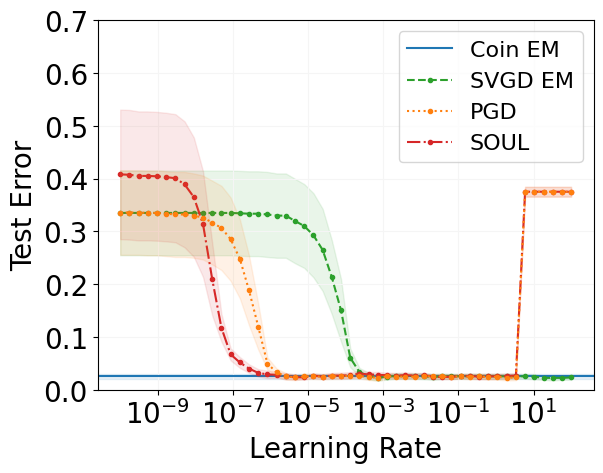

In [50]:
# Set up directory
fig_dir = "figures/bayes_lr"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
plt.axhline(coin_errors.mean(), color='C0', label='Coin EM')
plt.axhspan(coin_errors.mean() - coin_errors.std()/jnp.sqrt(10), coin_errors.mean() + coin_errors.std()/jnp.sqrt(10), alpha=0.1, color='C0')

plt.plot(step_sizes, adam_errors.mean(0), marker=".",label='SVGD EM', color='C2', linestyle="dashed")
plt.fill_between(step_sizes, adam_errors.mean(0) - adam_errors.std(0)/jnp.sqrt(10), adam_errors.mean(0) + adam_errors.std(0)/jnp.sqrt(10), alpha=0.1, color='C2')

plt.plot(step_sizes, pgd_errors.mean(0), marker='.', label='PGD', color='C1', linestyle='dotted', zorder=5)
plt.fill_between(step_sizes, pgd_errors.mean(0) - pgd_errors.std(0)/jnp.sqrt(10), pgd_errors.mean(0) + pgd_errors.std(0)/jnp.sqrt(10), alpha=0.1 , color='C1', zorder=5)

plt.plot(step_sizes, soul_errors.mean(0), marker='.', label='SOUL' , color='C3', linestyle='dashdot', zorder=2)
plt.fill_between(step_sizes, soul_errors.mean(0) - soul_errors.std(0)/jnp.sqrt(10), soul_errors.mean(0) + soul_errors.std(0)/jnp.sqrt(10), alpha=0.1 , color='C3', zorder=2)

#plt.plot(step_sizes, pmgd_errors.mean(0), marker='.', label='PMGD' , color='C4', linestyle='dashdot', zorder=2)
#plt.fill_between(step_sizes, pmgd_errors.mean(0) - pmgd_errors.std(0)/jnp.sqrt(10), pmgd_errors.mean(0) + pmgd_errors.std(0)/jnp.sqrt(10), alpha=0.1 , color='C4', zorder=2)

plt.xscale('log')
plt.xlabel('Learning Rate', fontsize=20)
plt.ylabel('Test Error', fontsize=20)
plt.legend(prop={'size': 16}, loc='upper right')
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,0.7)

save = True
if save:
    plt.savefig(fig_dir + "/" + "test_error_vs_lr" + test_id + ".pdf", dpi=300, bbox_inches="tight")
plt.show()


### (b) Log predictive denisty:

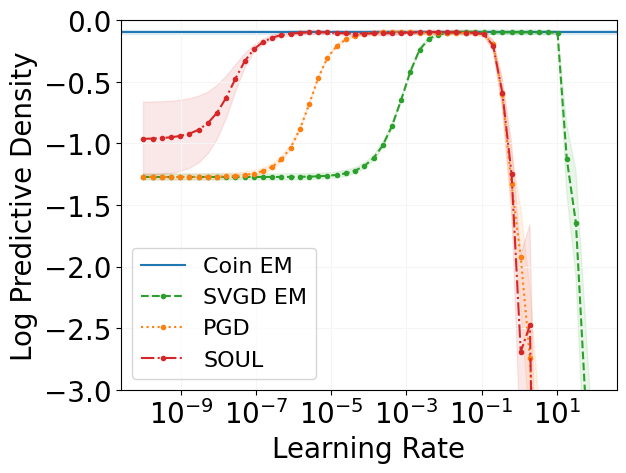

In [42]:
plt.axhline(coin_lppd.mean(), color='C0', label='Coin EM')
plt.axhspan(coin_lppd.mean() - coin_lppd.std()/jnp.sqrt(10), coin_lppd.mean() + coin_lppd.std()/jnp.sqrt(10), alpha=0.1, color='C0')

plt.plot(step_sizes, adam_lppd.mean(0), marker=".",label='SVGD EM', color='C2', linestyle="dashed")
plt.fill_between(step_sizes, adam_lppd.mean(0) - adam_lppd.std(0)/jnp.sqrt(10), adam_lppd.mean(0) + adam_lppd.std(0)/jnp.sqrt(10), alpha=0.1, color='C2')

plt.plot(step_sizes, pgd_lppd.mean(0), marker='.', label='PGD', color='C1', linestyle='dotted')
plt.fill_between(step_sizes, pgd_lppd.mean(0) - pgd_lppd.std(0)/jnp.sqrt(10), pgd_lppd.mean(0) + pgd_lppd.std(0)/jnp.sqrt(10), alpha=0.1 , color='C1')

plt.plot(step_sizes, soul_lppd.mean(0), marker='.', label='SOUL' , color='C3', linestyle='dashdot')
plt.fill_between(step_sizes, soul_lppd.mean(0) - soul_lppd.std(0)/jnp.sqrt(10), soul_lppd.mean(0) + soul_lppd.std(0)/jnp.sqrt(10), alpha=0.1 , color='C3')

#plt.plot(step_sizes, pmgd_lppd.mean(0), marker='.', label='PMGD' , color='C3', linestyle='dashdot')
#plt.fill_between(step_sizes, pmgd_lppd.mean(0) - pmgd_lppd.std(0)/jnp.sqrt(10), pmgd_lppd.mean(0) + pmgd_lppd.std(0)/jnp.sqrt(10), alpha=0.1 , color='C3')

plt.xscale('log')
plt.xlabel('Learning Rate', fontsize=20)
plt.ylabel('Log Predictive Density', fontsize=20)
plt.legend(prop={'size': 16}, loc='lower left')
plt.ylim(-3,0)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

save = True
if save:
    plt.savefig(fig_dir + "/" + "test_error_vs_lpdd" + test_id + ".pdf", dpi=300)
plt.show()

While for a given replicate, there is a learning rate that outperforms coin in this example, but varying the test train split, we see that coin is robust!